In [1]:
# Import some libraries

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

In [2]:
# Convert vector to image

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

In [50]:
# Displaying routine

def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(12, 4))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(12, 4))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

In [4]:
# Define data loading step

batch_size = 256

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Autoencoder from scratch

In [6]:
class MLP(nn.Module):
    def __init__(self, layers_io, activation = nn.ReLU()):
        super().__init__()
        
        layers_list = []
        for i, o in layers_io:
            layers_list.extend([nn.Linear(i, o), activation])
            
        self.sequence = nn.Sequential(*layers_list)
    
    def forward(self, x):
        return self.sequence(x)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_size, encoder_size, decoder_size, input_size, activation = nn.ReLU()):
        super().__init__()
        
        self.encoder = MLP(
            layers_io = zip([input_size] + encoder_size, encoder_size + [latent_size]),
            activation = activation)
        
        self.decoder = MLP(
            layers_io = zip([latent_size] + decoder_size, decoder_size + [input_size]),
            activation = activation)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [7]:
# Define model architecture and reconstruction loss

# n = 28 x 28 = 784
# d = 30  # for standard AE (under-complete hidden layer)
# d = 500  # for denoising AE (over-complete hidden layer)

#class Autoencoder(nn.Module):
    #def __init__(self):
        #super().__init__()
        #self.encoder = nn.Sequential(
            #nn.Linear(28 * 28, d),
            #nn.Tanh(),
        #)
        #self.decoder = nn.Sequential(
         #   nn.Linear(d, 28 * 28),
         #   nn.Tanh(),
        #)

    #def forward(self, x):
     #   x = self.encoder(x)
     #   x = self.decoder(x)
     #   return x
    
# model = Autoencoder().to(device)
# criterion = nn.MSELoss()

In [10]:
latent_size = 50 # for standard AE (under-complete hidden layer)
encoder_size = [400,200]
decoder_size = [100, 300]
input_size = 28*28
activation = nn.Tanh()

model = Autoencoder(latent_size, encoder_size, decoder_size, input_size, activation).to(device)
criterion = nn.MSELoss()

In [19]:
# Configure the optimiser

lr = 1e-3
num_epochs = 20

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [48]:
def train_model(num_epochs, AE_type = 'standard'):
    do = nn.Dropout()  # comment out for standard AE
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
    
        for data in dataloader:
            img,_ = data
            img = img.to(device)
            img = img.view(img.size(0), -1)
            
            # ===================dropout noise=====================
            if AE_type == 'dropout_noise':
                noise = do(torch.ones(img.shape)).to(device) # noise is a matrix of zeros and ones -> drop some pixels
                img_bad = (img * noise).to(device)  # comment out for standard AE
                output = model(img_bad) # <img_bad> (for denoising AE)
            # ===================randn noise=====================
            elif AE_type == 'randn_noise':
                randn_noise = (torch.normal(0, 0.25, size=(img.shape))).to(device)
                img_bad = (img + randn_noise).to(device)
                output = model(img_bad) # <img_bad> (for denoising AE)
            # ===================standard AE=====================
            else:
                output = model(img) # feed <img> (for std AE)
            
            loss = criterion(output, img.data)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        # update learning rate
        scheduler.step()
        
        # ===================log========================
        print(f'Loss:{loss.item():.4f}')
        print('-' * 10)
        if AE_type == 'dropout_noise' or AE_type == 'randn_noise':
            display_images(img_bad, output)  # (img_bad, output) for denoising AE
        else:
            display_images(None, output)  # pass (None, output) for std AE

Epoch 0/19
Loss:0.0154
----------
Epoch 1/19
Loss:0.0158
----------
Epoch 2/19
Loss:0.0155
----------
Epoch 3/19
Loss:0.0160
----------
Epoch 4/19
Loss:0.0142
----------
Epoch 5/19
Loss:0.0134
----------
Epoch 6/19
Loss:0.0155
----------
Epoch 7/19
Loss:0.0133
----------
Epoch 8/19
Loss:0.0136
----------
Epoch 9/19
Loss:0.0143
----------
Epoch 10/19
Loss:0.0155
----------
Epoch 11/19
Loss:0.0132
----------
Epoch 12/19
Loss:0.0147
----------
Epoch 13/19
Loss:0.0151
----------
Epoch 14/19
Loss:0.0156
----------
Epoch 15/19
Loss:0.0147
----------
Epoch 16/19
Loss:0.0159
----------
Epoch 17/19
Loss:0.0146
----------
Epoch 18/19
Loss:0.0157
----------
Epoch 19/19
Loss:0.0149
----------


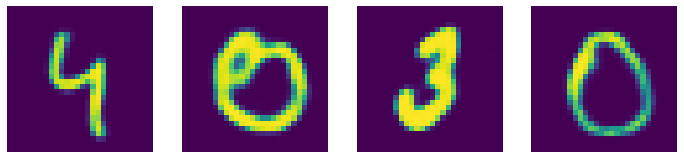

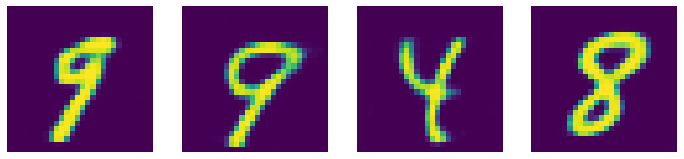

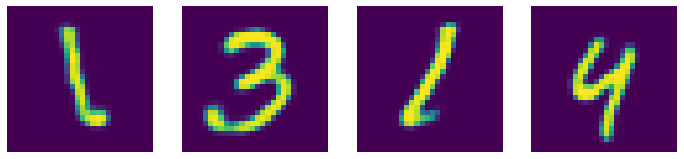

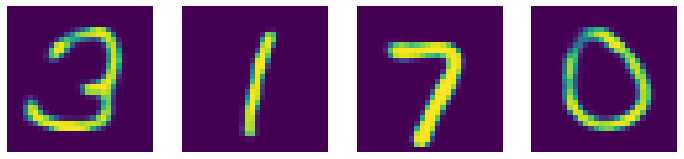

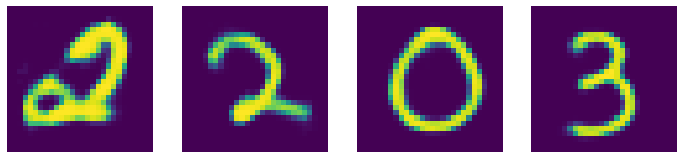

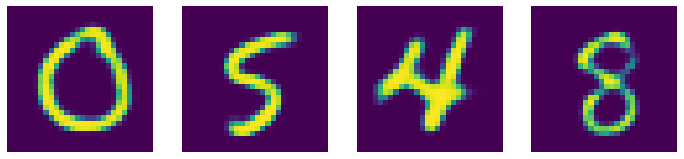

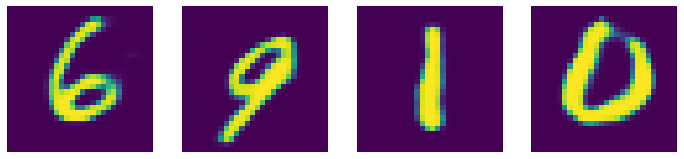

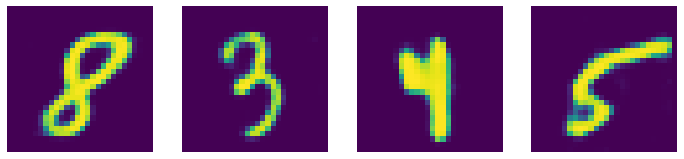

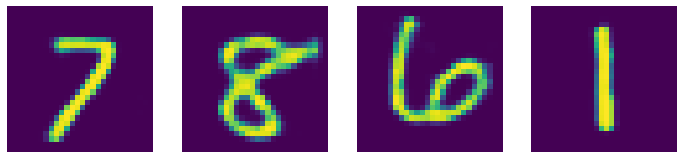

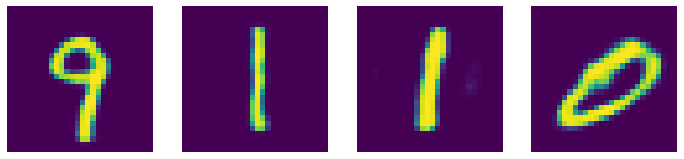

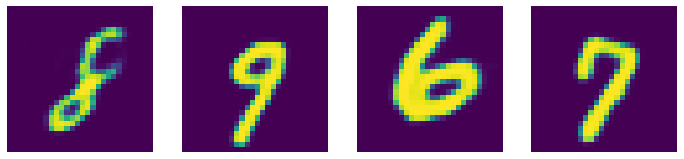

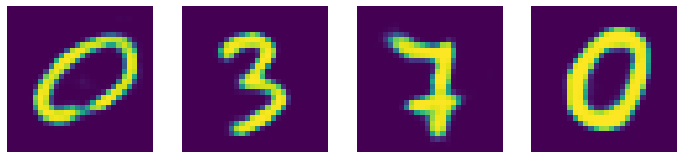

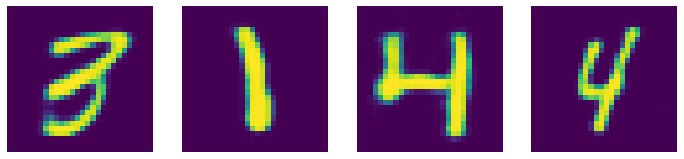

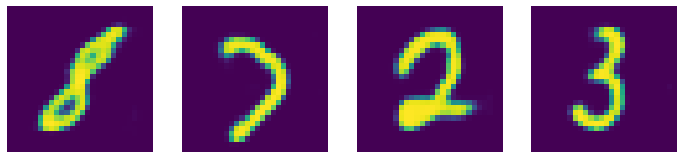

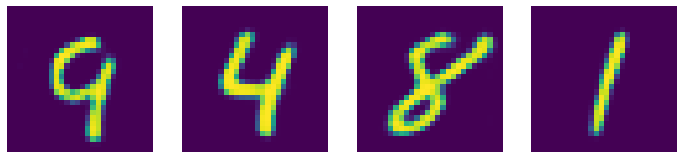

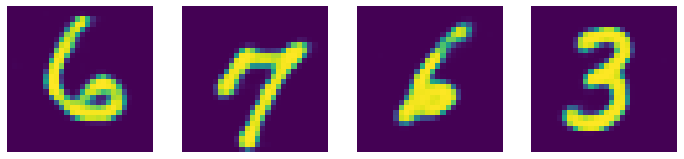

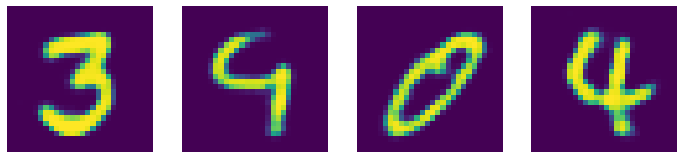

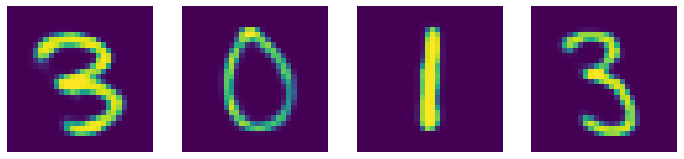

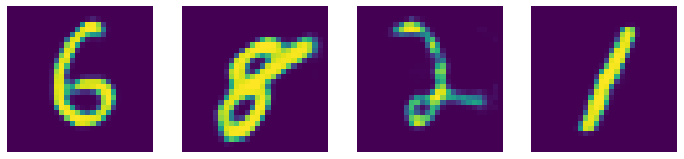

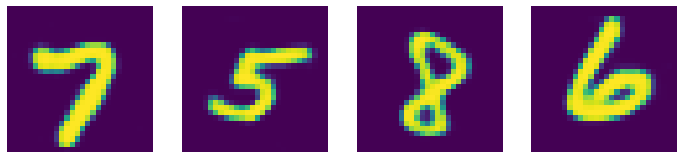

In [51]:
train_model(num_epochs, AE_type = 'standard')

Epoch 0/19
Loss:0.0827
----------
Epoch 1/19
Loss:0.0817
----------
Epoch 2/19
Loss:0.0767
----------
Epoch 3/19
Loss:0.0799
----------
Epoch 4/19
Loss:0.0815
----------
Epoch 5/19
Loss:0.0799
----------
Epoch 6/19
Loss:0.0791
----------
Epoch 7/19
Loss:0.0821
----------
Epoch 8/19
Loss:0.0769
----------
Epoch 9/19
Loss:0.0742
----------
Epoch 10/19
Loss:0.0756
----------


C:\Users\miguelfarinha\AppData\Local\Temp\ipykernel_2212\770897927.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 4))


Epoch 11/19
Loss:0.0836
----------
Epoch 12/19
Loss:0.0826
----------
Epoch 13/19
Loss:0.0851
----------
Epoch 14/19
Loss:0.0792
----------
Epoch 15/19
Loss:0.0771
----------
Epoch 16/19
Loss:0.0787
----------
Epoch 17/19
Loss:0.0851
----------
Epoch 18/19
Loss:0.0792
----------
Epoch 19/19
Loss:0.0746
----------


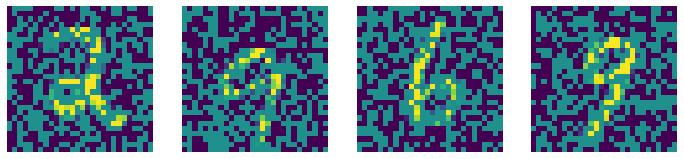

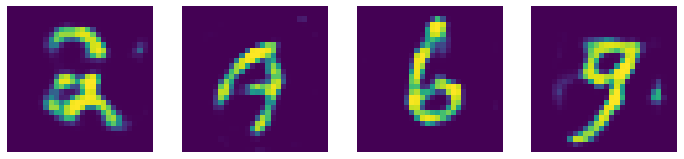

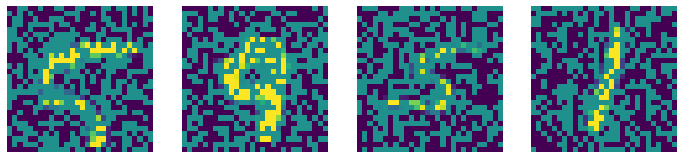

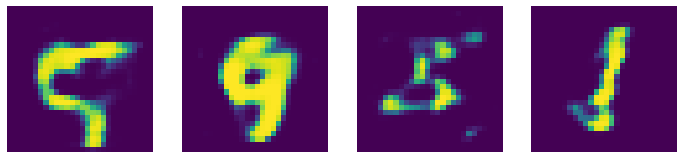

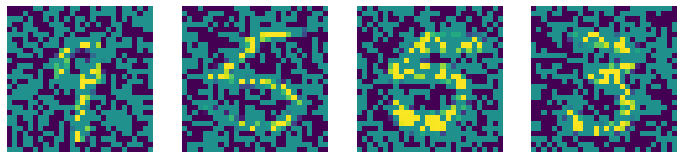

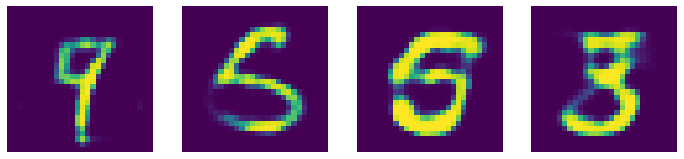

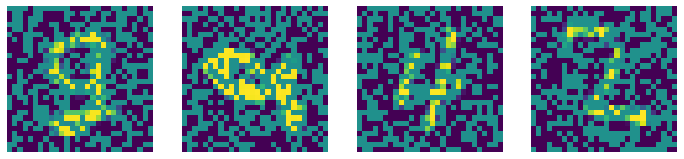

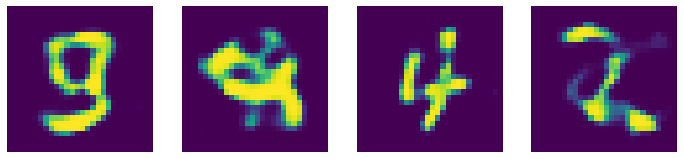

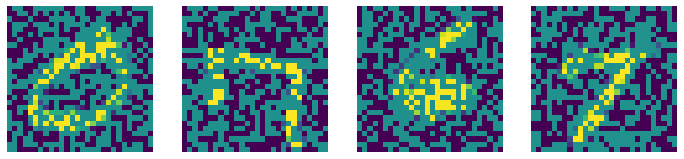

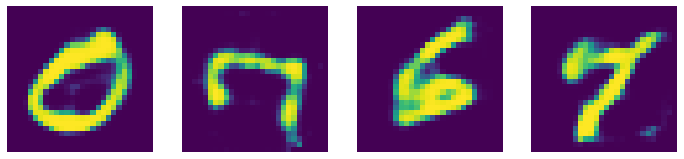

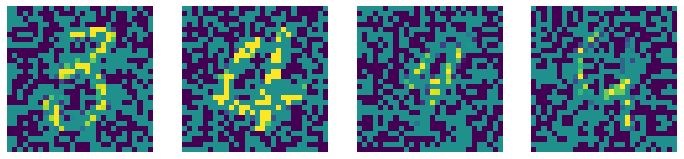

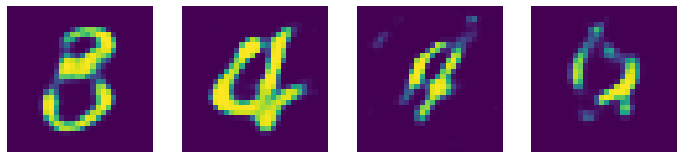

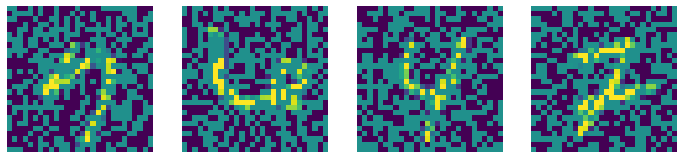

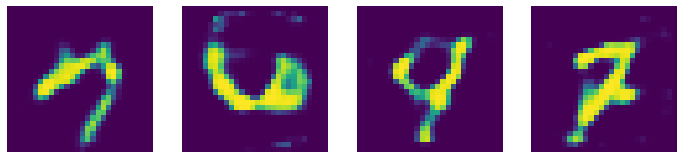

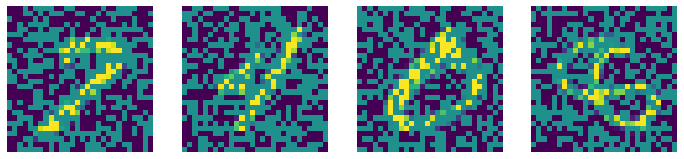

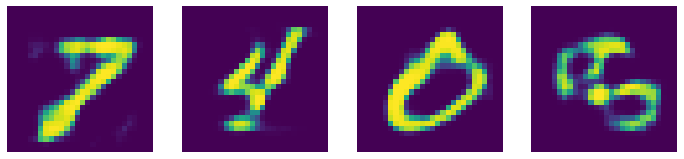

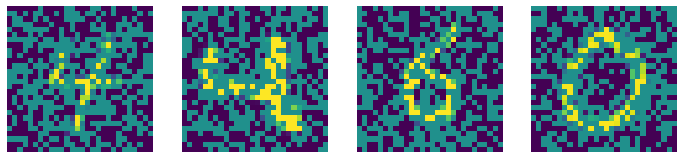

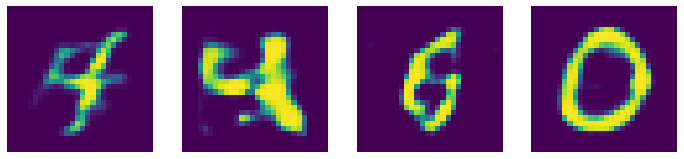

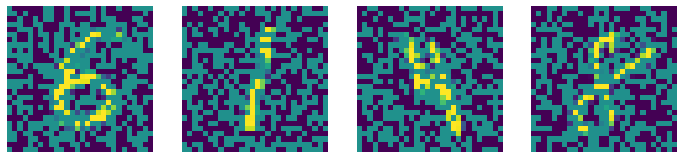

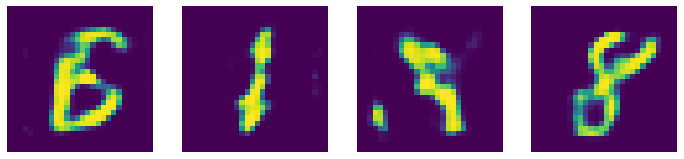

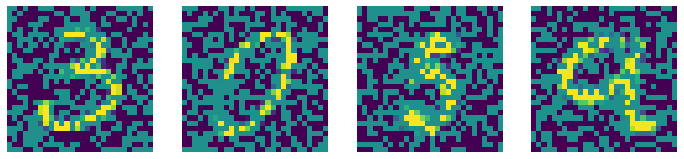

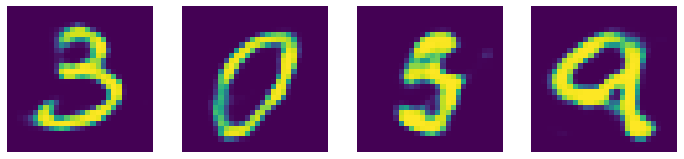

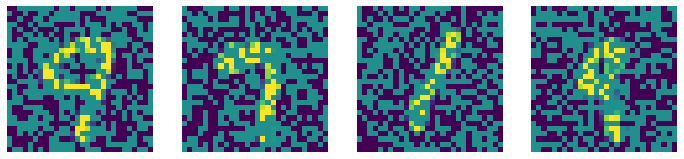

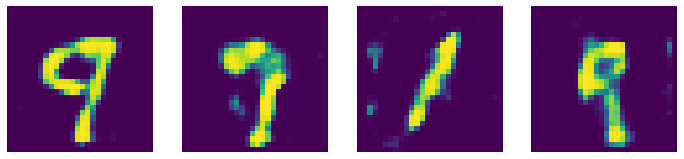

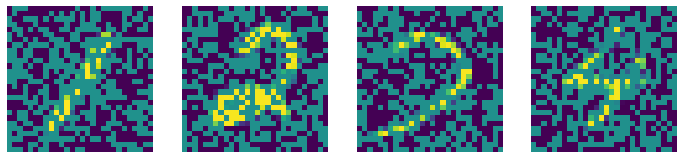

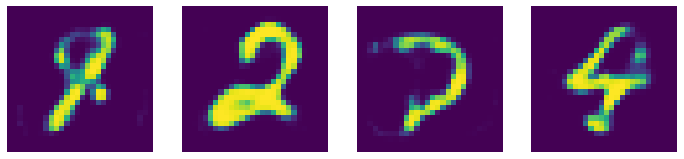

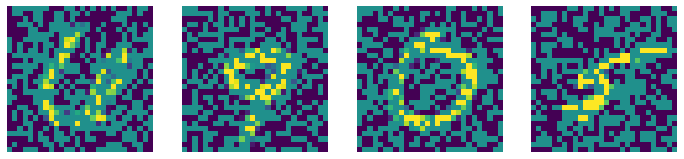

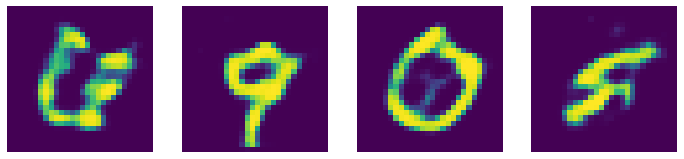

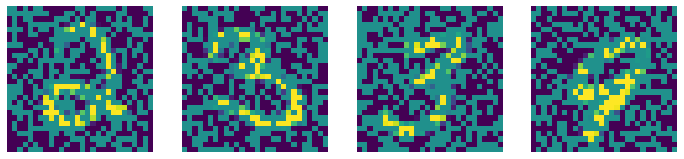

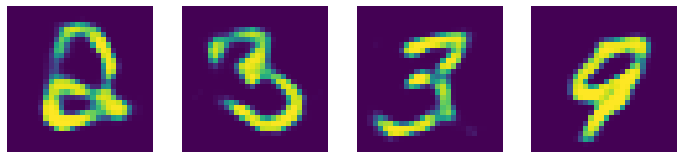

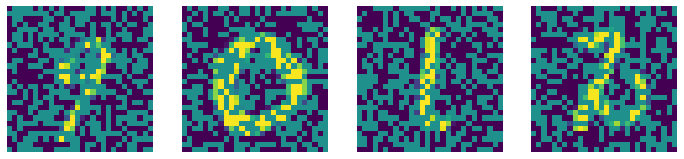

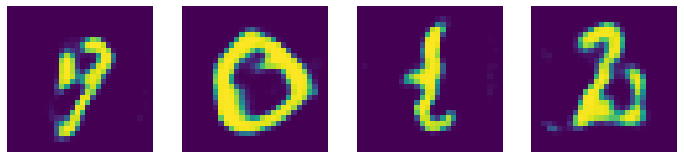

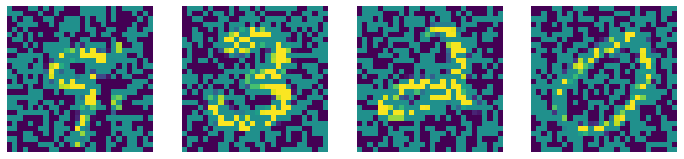

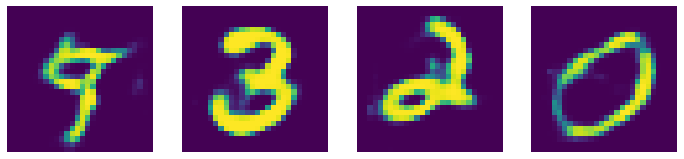

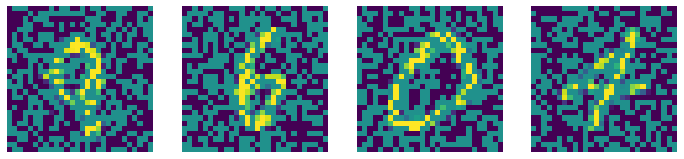

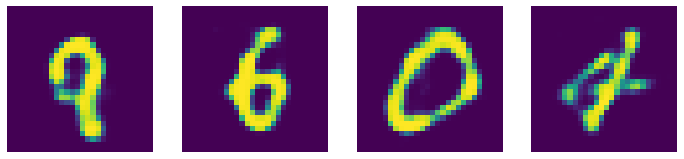

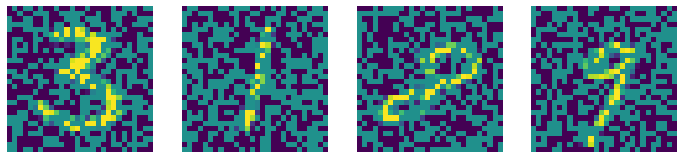

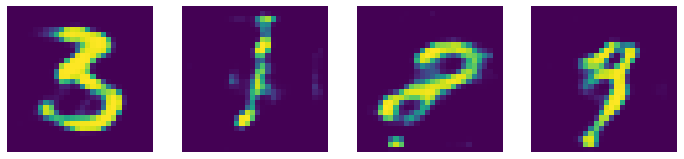

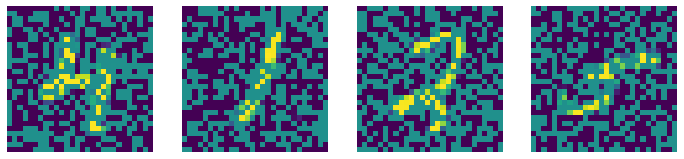

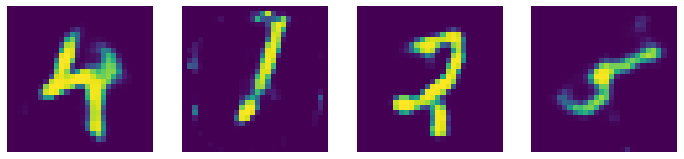

In [52]:
train_model(num_epochs, AE_type = 'dropout_noise')

Epoch 0/19
Loss:0.0221
----------
Epoch 1/19
Loss:0.0230
----------
Epoch 2/19
Loss:0.0210
----------
Epoch 3/19
Loss:0.0235
----------
Epoch 4/19
Loss:0.0230
----------
Epoch 5/19
Loss:0.0223
----------
Epoch 6/19
Loss:0.0227
----------
Epoch 7/19
Loss:0.0226
----------
Epoch 8/19
Loss:0.0225
----------
Epoch 9/19
Loss:0.0231
----------
Epoch 10/19
Loss:0.0220
----------
Epoch 11/19


C:\Users\miguelfarinha\AppData\Local\Temp\ipykernel_2212\770897927.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 4))


Loss:0.0202
----------
Epoch 12/19
Loss:0.0228
----------
Epoch 13/19
Loss:0.0233
----------
Epoch 14/19
Loss:0.0233
----------
Epoch 15/19
Loss:0.0208
----------
Epoch 16/19
Loss:0.0233
----------
Epoch 17/19
Loss:0.0236
----------
Epoch 18/19
Loss:0.0239
----------
Epoch 19/19
Loss:0.0216
----------


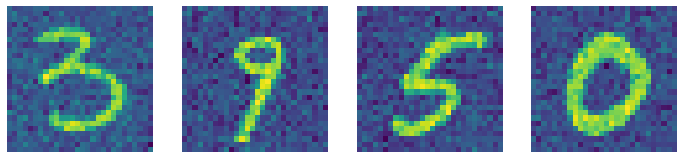

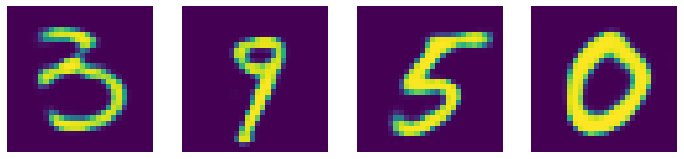

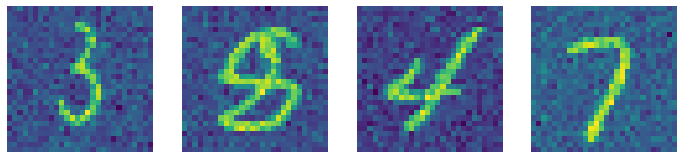

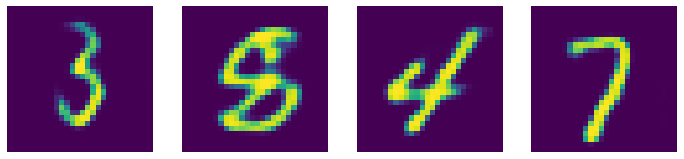

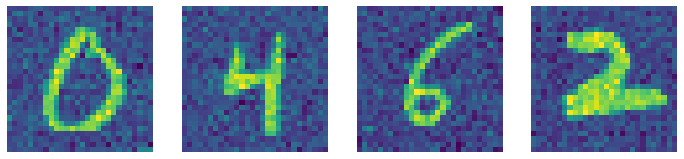

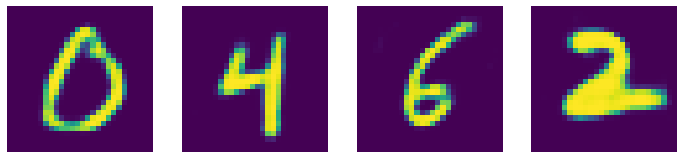

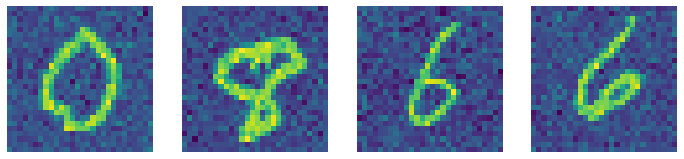

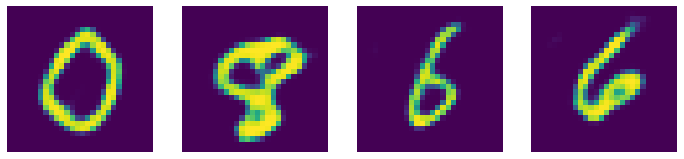

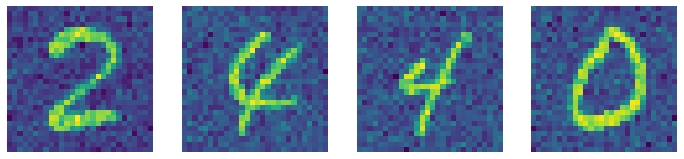

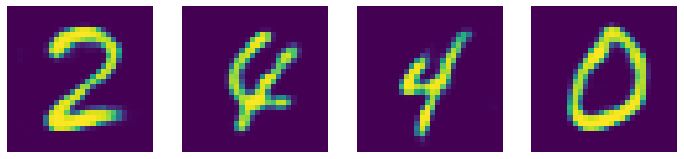

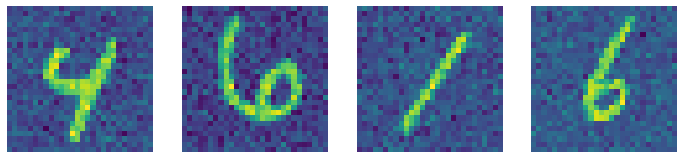

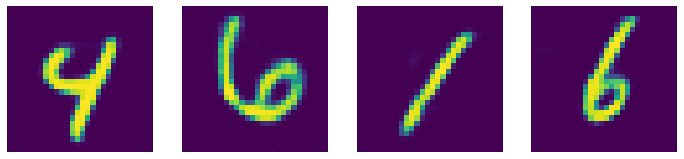

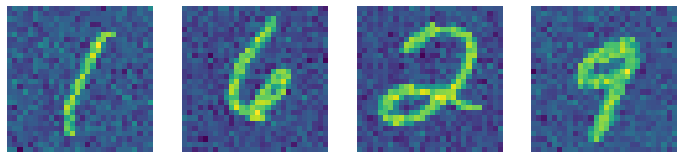

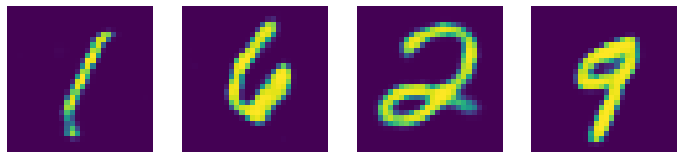

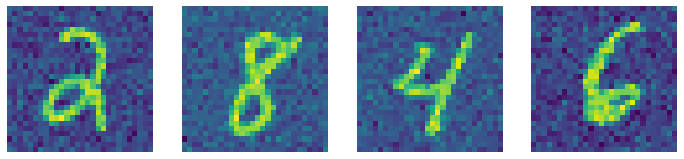

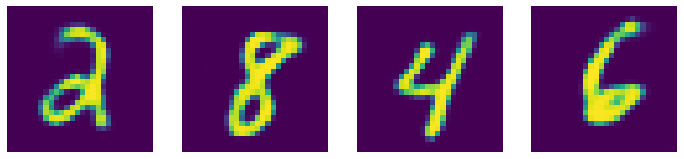

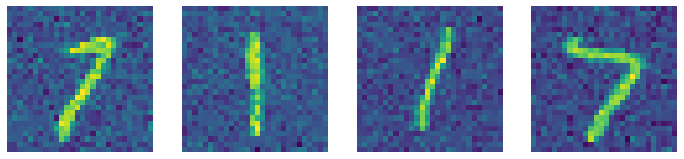

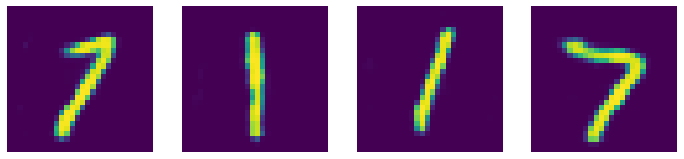

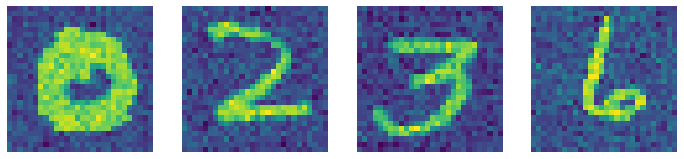

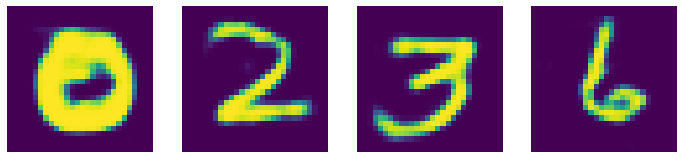

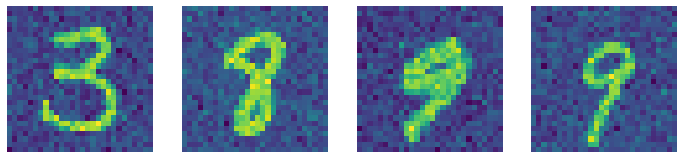

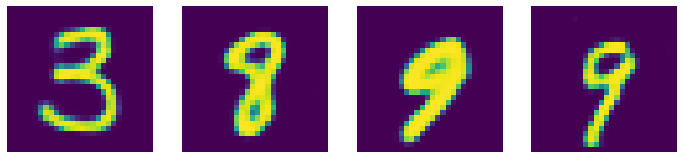

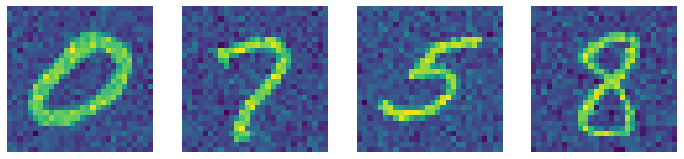

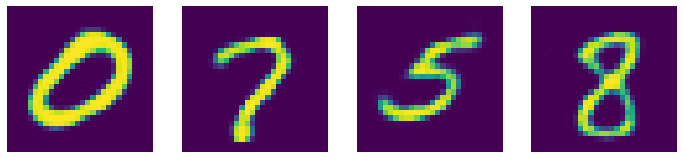

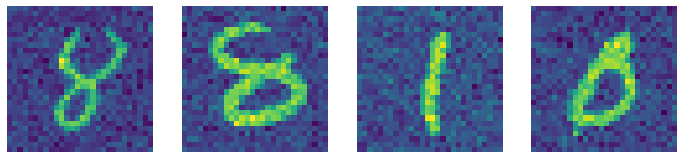

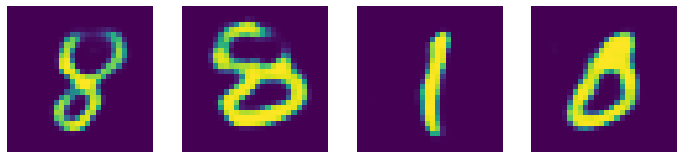

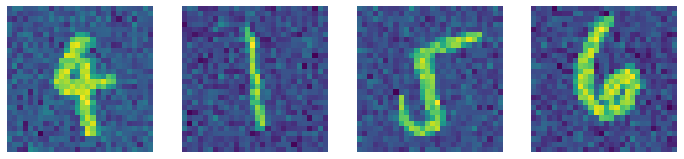

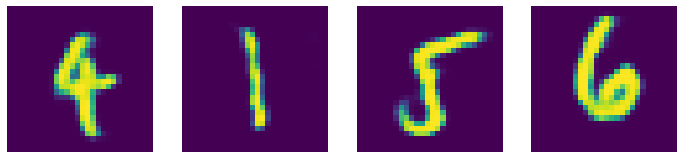

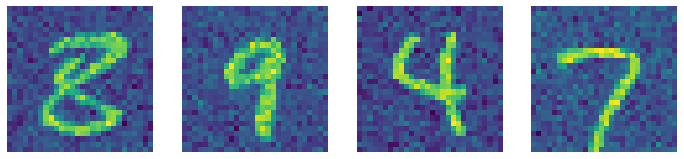

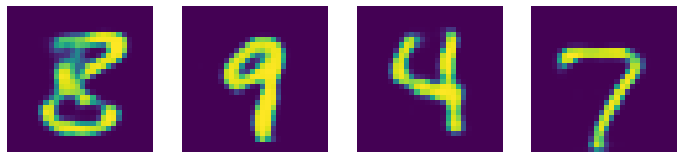

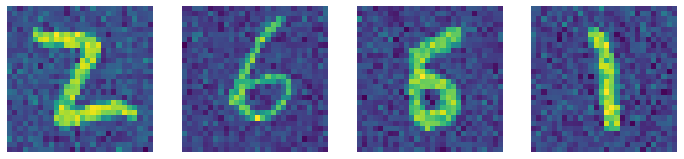

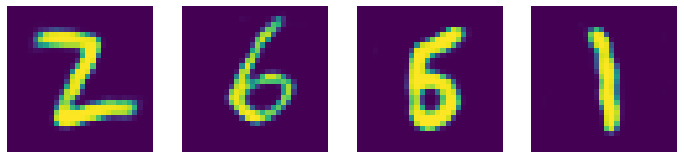

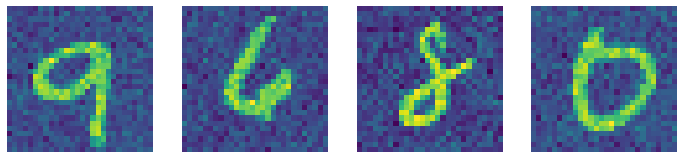

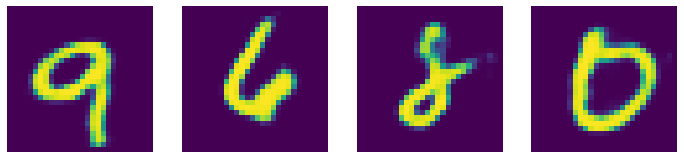

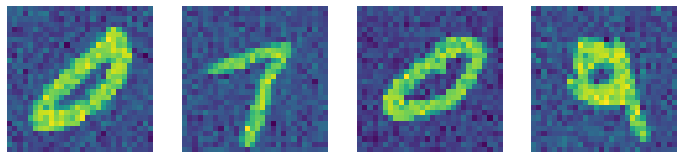

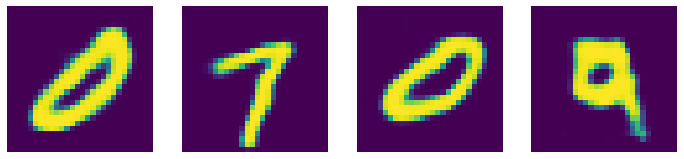

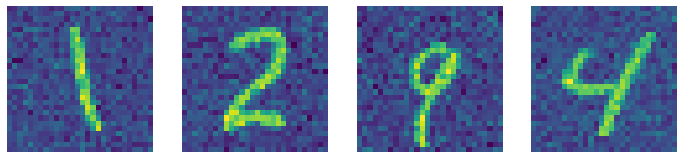

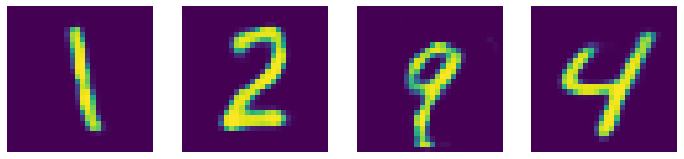

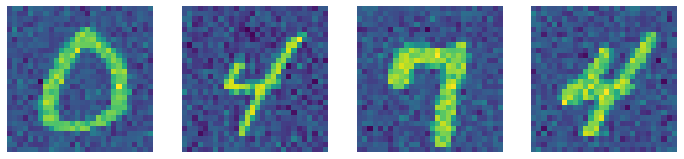

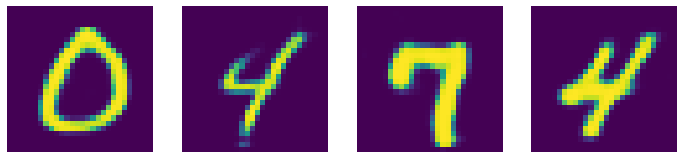

In [53]:
train_model(num_epochs, AE_type = 'randn_noise')

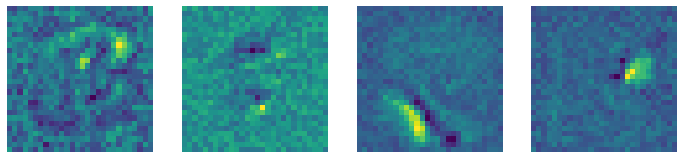

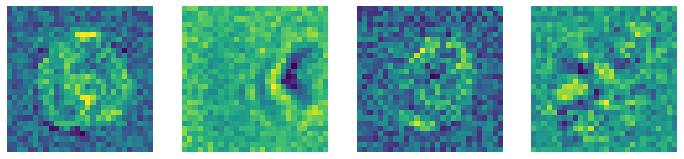

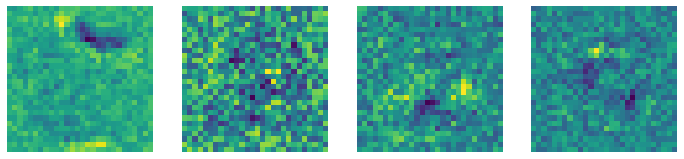

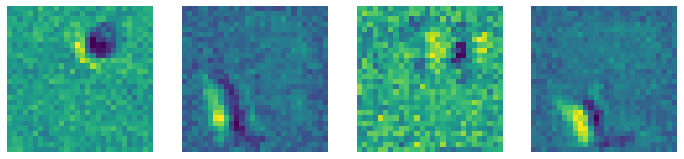

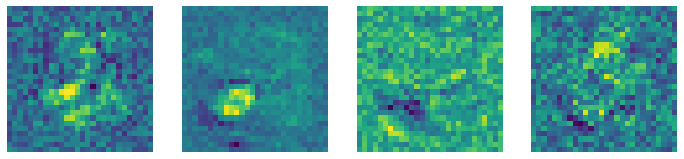

In [65]:
# Visualise a few kernels of the encoder

display_images(None, model.encoder.sequence[0].weight, 5)

In [67]:
# Let's compare the autoencoder inpainting capabilities vs. OpenCV
# RUN THIS ONLY AFTER HAVING TRAINED A DENOISING AE!!!

from cv2 import inpaint, INPAINT_NS, INPAINT_TELEA

In [75]:
# Inpaint with Telea and Navier-Stokes methods

dst_TELEA = list()
dst_NS = list()

for i in range(3, 7):
    corrupted_img = ((img_bad.data.cpu()[i].view(28, 28) / 4 + 0.5) * 255).byte().numpy()
    mask = 2 - randn_noise.cpu()[i].view(28, 28).byte().numpy()
    dst_TELEA.append(inpaint(corrupted_img, mask, 3, INPAINT_TELEA))
    dst_NS.append(inpaint(corrupted_img, mask, 3, INPAINT_NS))

tns_TELEA = [torch.from_numpy(d) for d in dst_TELEA]
tns_NS = [torch.from_numpy(d) for d in dst_NS]

TELEA = torch.stack(tns_TELEA).float()
NS = torch.stack(tns_NS).float()

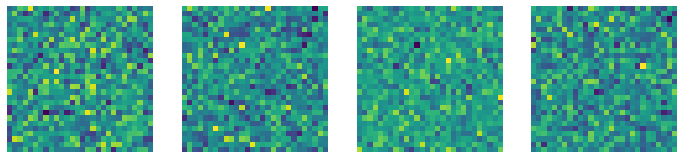

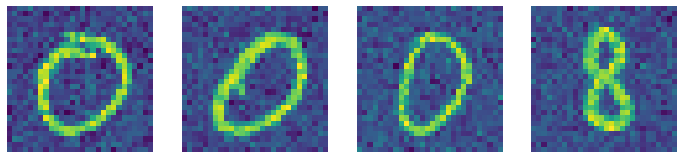

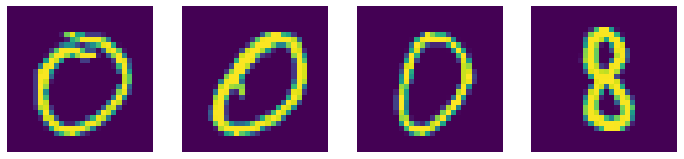

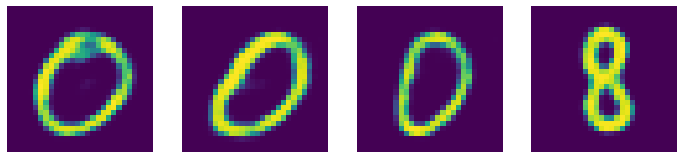

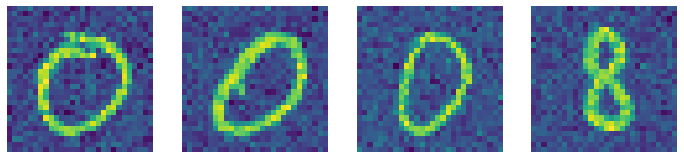

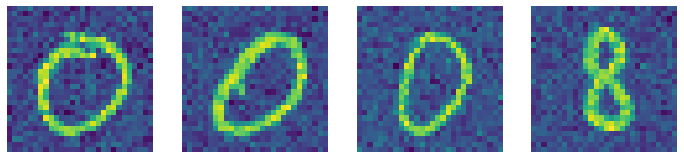

In [76]:
# Compare the results: [noise], [img + noise], [img], [AE, Telea, Navier-Stokes] inpainting

with torch.no_grad():
    display_images(randn_noise[3:7], img_bad[3:7])
    display_images(img[3:7], output[3:7])
    display_images(TELEA, NS)

## Vizualizing the latent space

In [95]:
# dataset.train_data = dataset.train_data.view(dataset.train_data.size(0), -1)
imgs = dataset.train_data.view(dataset.train_data.size(0), -1)

In [100]:
with torch.no_grad():
    latents = model.encoder(imgs.float().to(device)).cpu().detach().numpy()
latents.shape

(60000, 50)

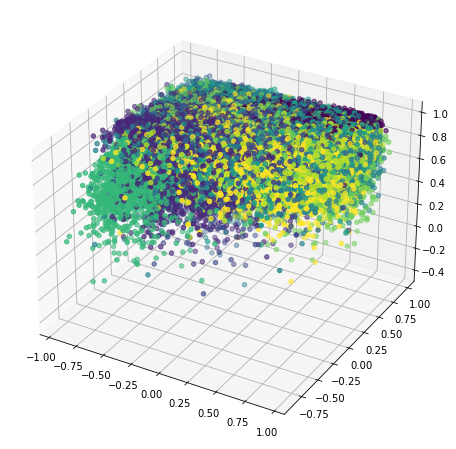

In [101]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
ax.scatter3D(latents[:,0],latents[:,1], latents[:,2], c=dataset.train_labels);

# Experimenting with sklearn faces dataset

In [149]:
from sklearn.datasets import fetch_olivetti_faces

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True,
                                random_state=1)
faces.shape

(400, 4096)

In [150]:
# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(faces.shape[0], -1)

In [151]:
# Define data loading step

batch_size = 26

img_transform = transforms.Compose([
    transforms.ToTensor()
])

faces = img_transform(faces_centered)
faces = faces.squeeze(0)
faces.shape

torch.Size([400, 4096])

In [206]:
# Convert vector to image

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 64, 64)
    return x

# Displaying routine

def display_images(in_, out, n=1, cmap=plt.cm.gray):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            vmax = max(in_pic.max(), -in_pic.min())
            plt.figure(figsize=(12, 4))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N], cmap=cmap, interpolation='nearest', vmin=-vmax, vmax=vmax)
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        vmax = max(out_pic.max(), -out_pic.min())
        plt.figure(figsize=(12, 4))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N],cmap=cmap, interpolation='nearest', vmin=-vmax, vmax=vmax)
            plt.axis('off')

In [207]:
dataloader = DataLoader(faces, batch_size=batch_size, shuffle=True)

In [208]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [209]:
class MLP(nn.Module):
    def __init__(self, layers_io, activation = nn.ReLU()):
        super().__init__()
        
        layers_list = []
        for i, o in layers_io:
            layers_list.extend([nn.Linear(i, o), activation])
            
        self.sequence = nn.Sequential(*layers_list)
    
    def forward(self, x):
        return self.sequence(x)

class Autoencoder(nn.Module):
    def __init__(self, latent_size, encoder_size, decoder_size, input_size, activation = nn.ReLU()):
        super().__init__()
        
        self.encoder = MLP(
            layers_io = zip([input_size] + encoder_size, encoder_size + [latent_size]),
            activation = activation)
        
        self.decoder = MLP(
            layers_io = zip([latent_size] + decoder_size, decoder_size + [input_size]),
            activation = activation)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [221]:
latent_size = 200 # for standard AE (under-complete hidden layer)
encoder_size = [1500,750,325]
decoder_size = [500,800,2000]
input_size = 64*64
activation = nn.Tanh()

model = Autoencoder(latent_size, encoder_size, decoder_size, input_size, activation).to(device)
criterion = nn.MSELoss()

In [222]:
# Configure the optimiser

lr = 1e-3
num_epochs = 20

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [223]:
xb = next(iter(dataloader))
xb.shape

torch.Size([26, 4096])

In [224]:
def train_model(num_epochs, AE_type = 'standard'):
    do = nn.Dropout()  # comment out for standard AE
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
    
        for img in dataloader:
            img = img.to(device)
            
            # ===================dropout noise=====================
            if AE_type == 'dropout_noise':
                noise = do(torch.ones(img.shape)).to(device) # noise is a matrix of zeros and ones -> drop some pixels
                img_bad = (img * noise).to(device)  # comment out for standard AE
                output = model(img_bad) # <img_bad> (for denoising AE))
            # ===================standard AE=====================
            else:
                output = model(img) # feed <img> (for std AE)
            
            loss = criterion(output, img.data)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        # update learning rate
        scheduler.step()
        
        # ===================log========================
        print(f'Loss:{loss.item():.4f}')
        print('-' * 10)
        if AE_type == 'dropout_noise':
            display_images(img_bad, output)  # (img_bad, output) for denoising AE
        else:
            display_images(None, output)  # pass (None, output) for std AE

Epoch 0/19
Loss:0.0110
----------
Epoch 1/19
Loss:0.0112
----------
Epoch 2/19
Loss:0.0080
----------
Epoch 3/19
Loss:0.0070
----------
Epoch 4/19
Loss:0.0075
----------
Epoch 5/19
Loss:0.0056
----------
Epoch 6/19
Loss:0.0072
----------
Epoch 7/19
Loss:0.0073
----------
Epoch 8/19
Loss:0.0067
----------
Epoch 9/19
Loss:0.0060
----------
Epoch 10/19
Loss:0.0050
----------
Epoch 11/19
Loss:0.0043
----------
Epoch 12/19
Loss:0.0042
----------
Epoch 13/19
Loss:0.0034
----------
Epoch 14/19
Loss:0.0034
----------
Epoch 15/19
Loss:0.0036
----------
Epoch 16/19
Loss:0.0035
----------
Epoch 17/19
Loss:0.0035
----------
Epoch 18/19
Loss:0.0036
----------
Epoch 19/19
Loss:0.0032
----------


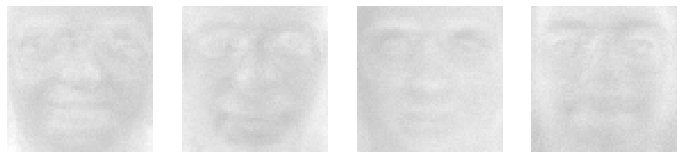

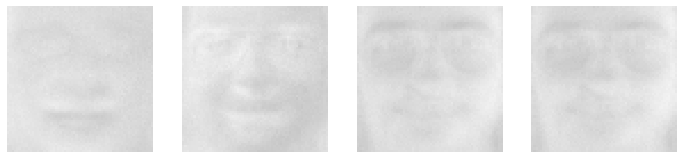

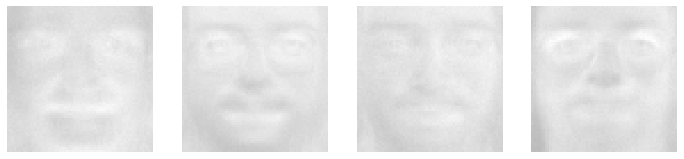

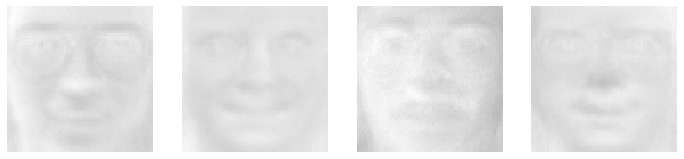

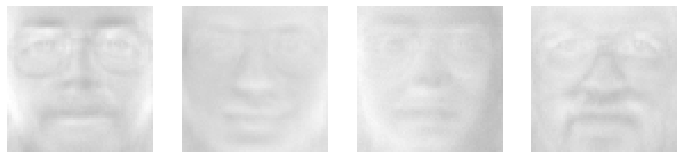

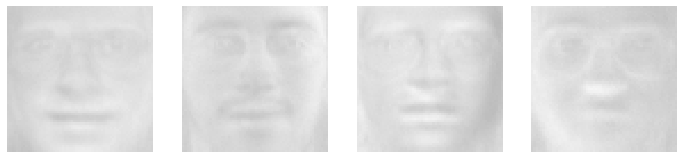

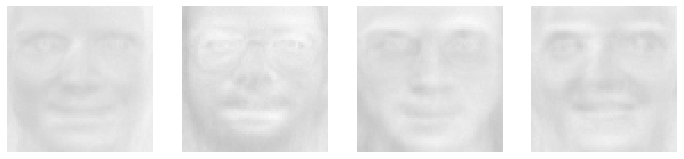

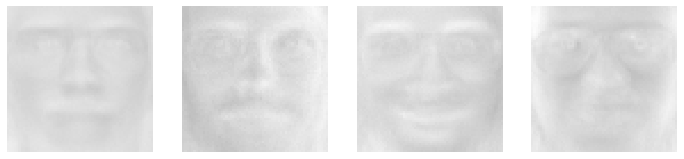

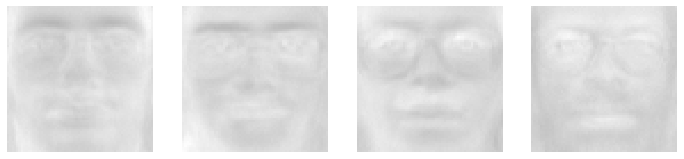

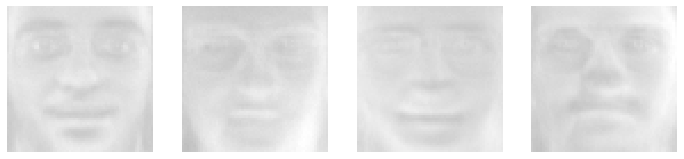

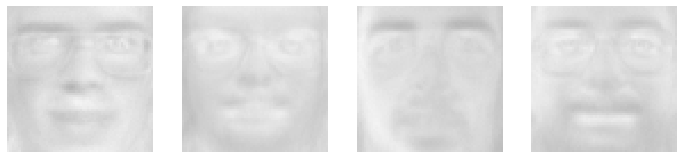

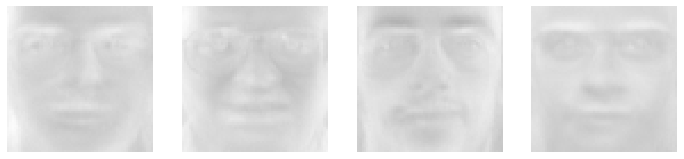

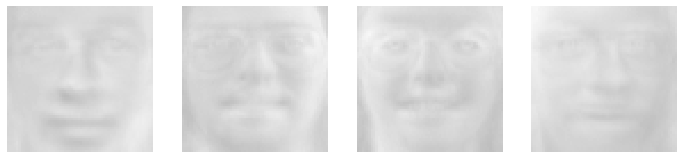

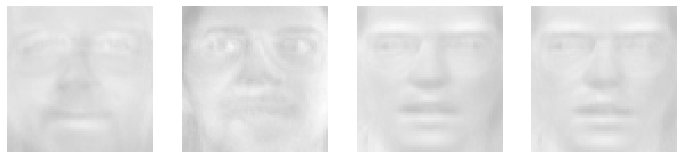

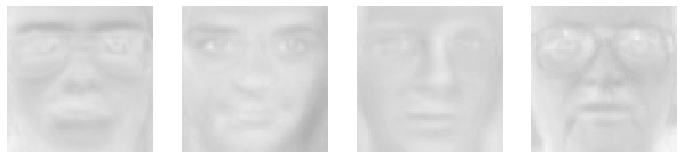

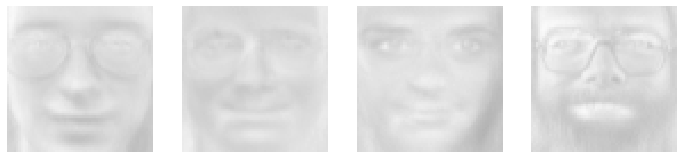

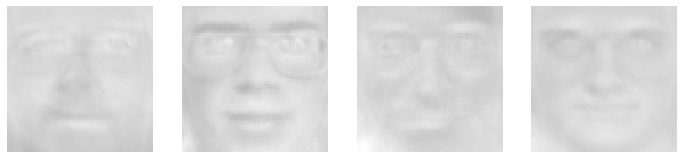

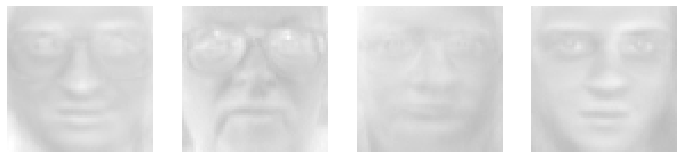

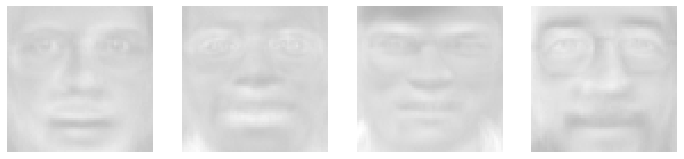

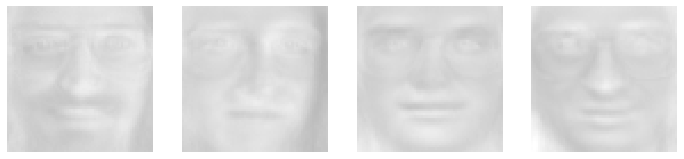

In [225]:
train_model(num_epochs)

Epoch 0/19
Loss:0.0034
----------
Epoch 1/19
Loss:0.0033
----------
Epoch 2/19
Loss:0.0034
----------
Epoch 3/19
Loss:0.0031
----------
Epoch 4/19
Loss:0.0041
----------
Epoch 5/19
Loss:0.0039
----------
Epoch 6/19
Loss:0.0037
----------
Epoch 7/19
Loss:0.0034
----------
Epoch 8/19
Loss:0.0034
----------
Epoch 9/19
Loss:0.0028
----------
Epoch 10/19
Loss:0.0035
----------
Epoch 11/19


C:\Users\miguelfarinha\AppData\Local\Temp\ipykernel_2212\1737145814.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 4))


Loss:0.0032
----------
Epoch 12/19
Loss:0.0037
----------
Epoch 13/19
Loss:0.0034
----------
Epoch 14/19
Loss:0.0041
----------
Epoch 15/19
Loss:0.0038
----------
Epoch 16/19
Loss:0.0036
----------
Epoch 17/19
Loss:0.0036
----------
Epoch 18/19
Loss:0.0032
----------
Epoch 19/19
Loss:0.0038
----------


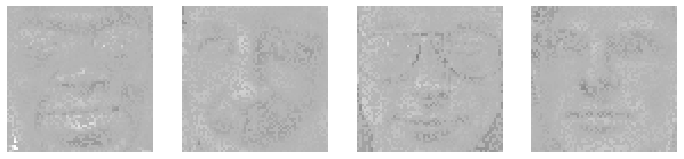

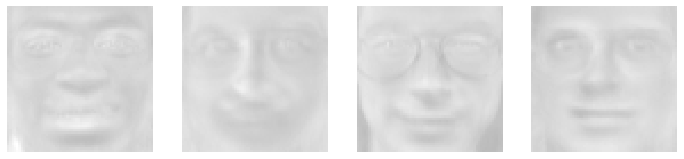

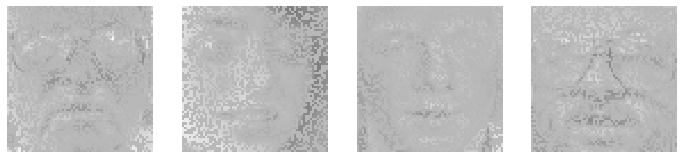

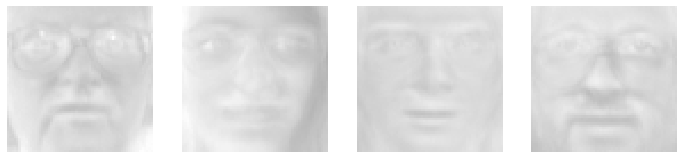

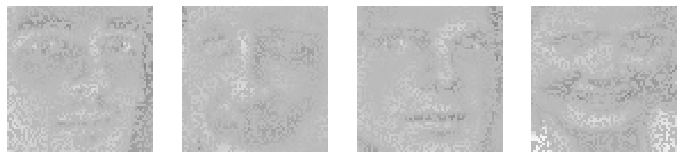

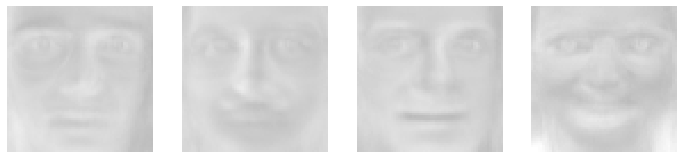

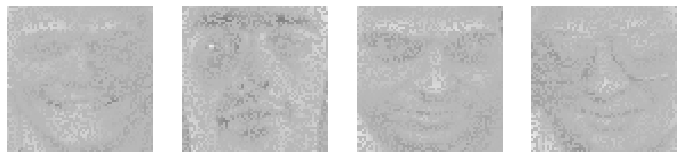

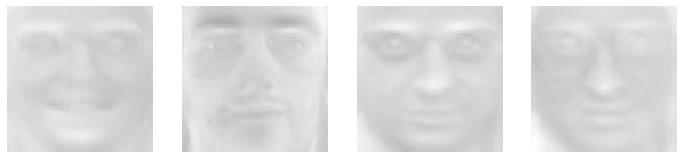

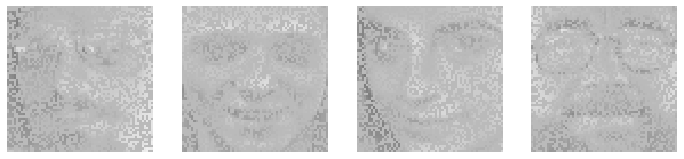

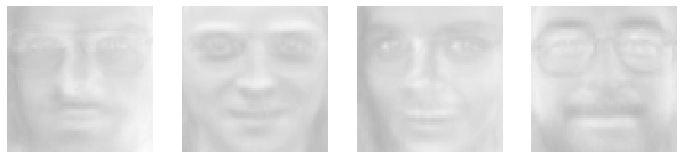

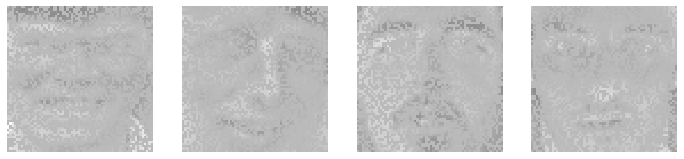

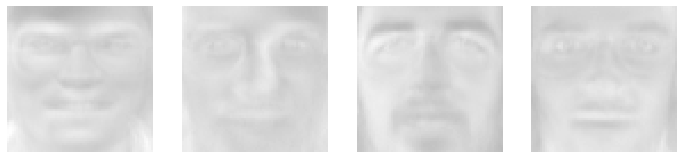

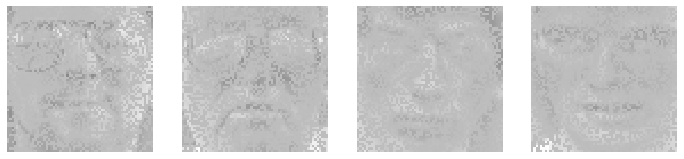

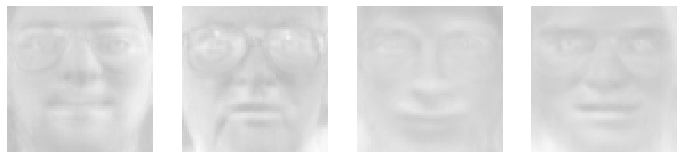

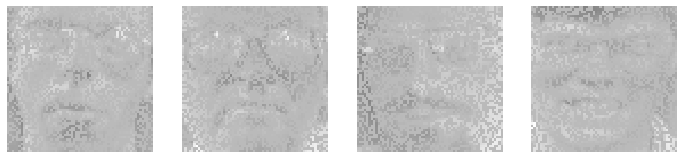

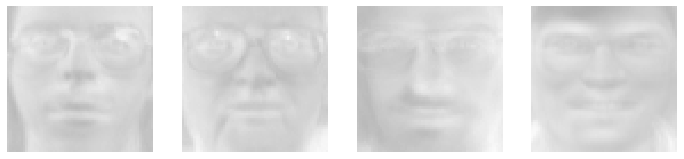

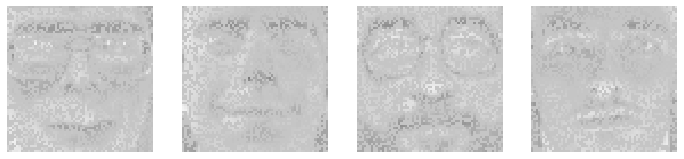

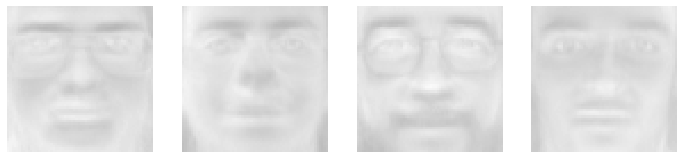

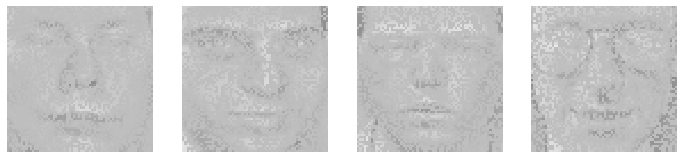

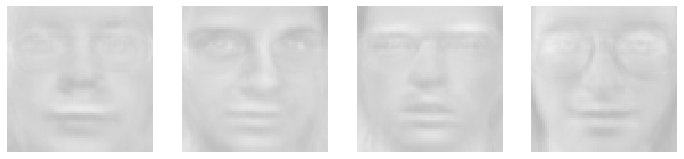

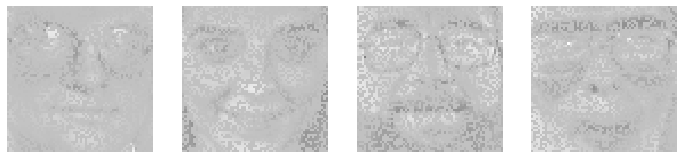

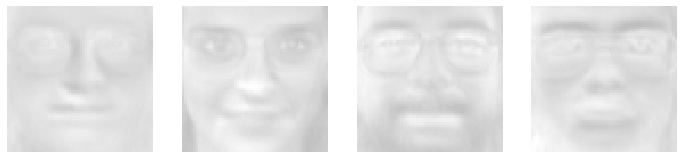

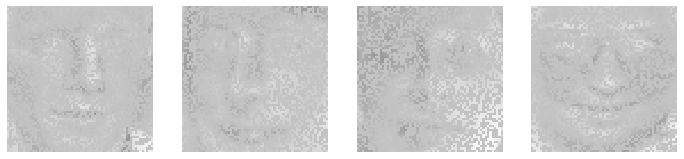

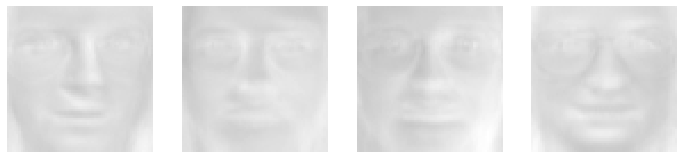

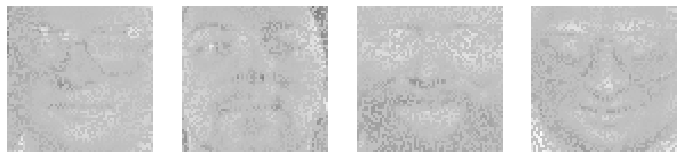

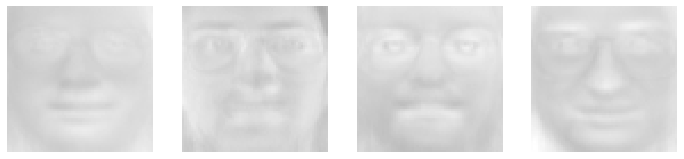

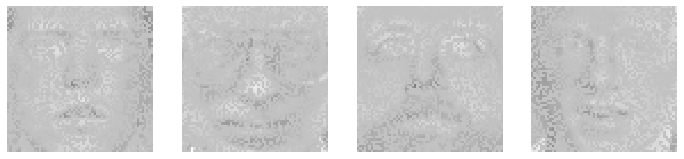

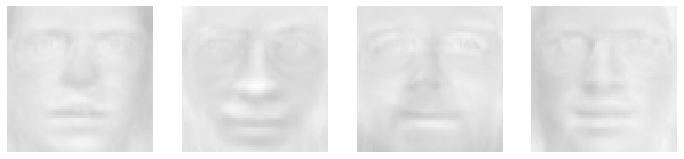

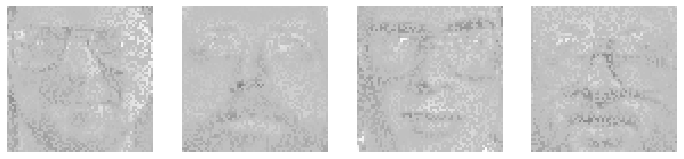

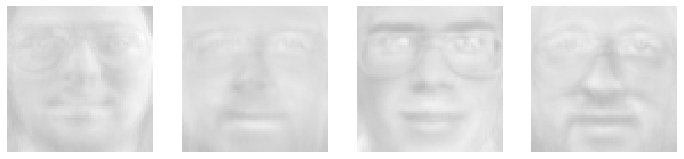

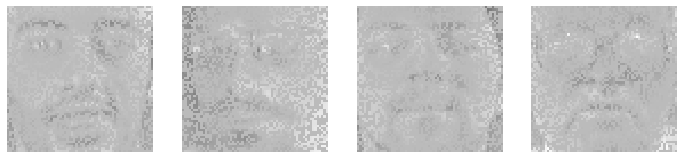

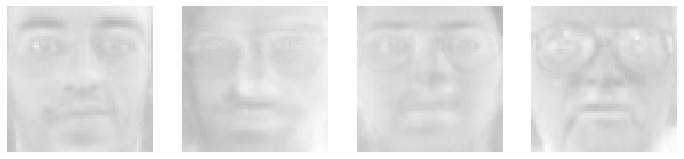

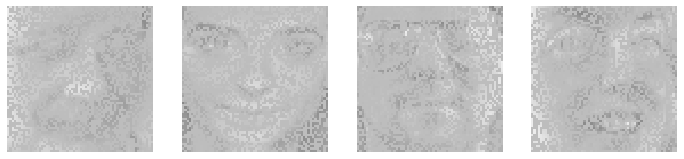

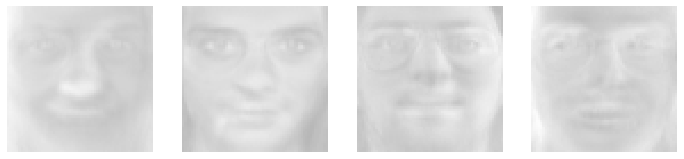

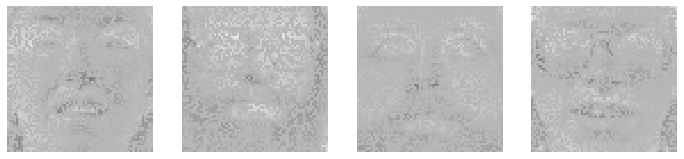

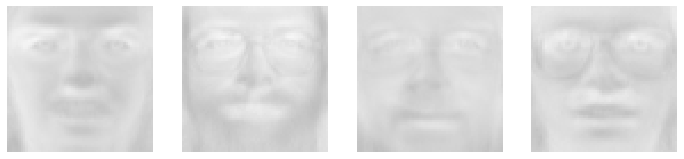

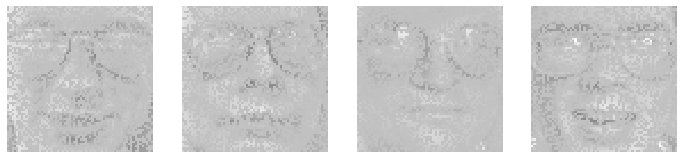

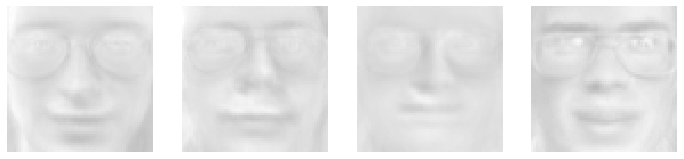

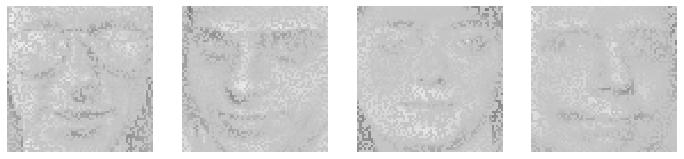

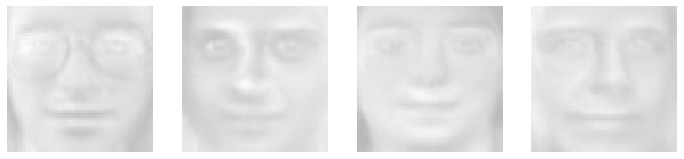

In [226]:
train_model(num_epochs, AE_type = 'dropout_noise')